# Justifying $K$
This notebook provides the code to prove the following hypothesis: $K$ (i.e. cardinality proportion) can adequately distinguish between semantic and syntactic joins in a dataset, thus evidencing its important role as a complimentary metric to provide a lightweight assessment of the semantic relationships between columns.

To do so, we need to compute semantic and syntactic joins for benchmarks. To do so, we wil apply the same criteria as with Freyja's benchmark: 
- A join is syntactic if the containment between columns in higher than 0.3. 
- A join is semantic if it is syntactic and there exists a semantic link between the columns.

The syntactic joins are straightforward to compute: just iterate over the benchmark and find joins that have a high containment. Semantic joins are trickier, as defining them would imply manually assessing the semantic link (as we have done with the Freyja benchmark). As doing so encompasses a disproportionate amount of work, we have opted for employing each benchmark's ground truth. That is, we assume that the joins indicated in the ground truths have a high containment and share semantic meaning.

In [1]:
import duckdb
import glob
import os
import pandas as pd
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

def safe_column_comparison_query(table1, col1, table2, col2): # Function to generate safe query column pairs
    return f"""
        WITH
            uniq1 AS (
                SELECT DISTINCT "{col1}" AS val FROM "{table1}" WHERE "{col1}" IS NOT NULL
            ),
            uniq2 AS (
                SELECT DISTINCT "{col2}" AS val FROM "{table2}" WHERE "{col2}" IS NOT NULL
            ),
            intersection AS (
                SELECT val FROM uniq1
                INTERSECT
                SELECT val FROM uniq2
            )
        SELECT
            (SELECT COUNT(*) FROM uniq1) AS unique_count_col1,
            (SELECT COUNT("{col1}") FROM "{table1}" WHERE "{col1}" IS NOT NULL) AS count_col1,
            (SELECT COUNT(*) FROM uniq2) AS unique_count_col2,
            (SELECT COUNT("{col2}") FROM "{table2}" WHERE "{col2}" IS NOT NULL) AS count_col2,
            (SELECT COUNT(*) FROM intersection) AS intersection_count;
    """


In [11]:
BENCHMARK_NAME = "d3l"
DATA_FOLDER = f"C:/Projects/benchmarks/{BENCHMARK_NAME}/datalake"  # path to CSVs
SAMPLE_SIZE = 15000 # This is the amount of joins that will be tested to find syntactic joins. The more joins, the more syntactic joins that will be found

Step 1: Load CSVs into DuckDB and build metadata

In [ ]:
con = duckdb.connect(database=':memory:') # DuckDB in-memory connection

# Load CSV files into DuckDB tables
csv_files = [
    f for f in glob.glob(os.path.join(DATA_FOLDER, "*.csv"))
    if "t_013a2f8c584d44d7" not in f  # Exclude problematic files
]

for file in tqdm(csv_files):
    table_name = os.path.splitext(os.path.basename(file))[0]
    con.execute(f"""
        CREATE VIEW "{table_name}" AS
        SELECT * FROM read_csv_auto('{file}', IGNORE_ERRORS=TRUE)
    """)

print(f"Loaded {len(csv_files)} tables into DuckDB.")

100%|██████████| 550/550 [00:12<00:00, 43.27it/s] 

Loaded 550 tables into DuckDB.


Step 2: Generate and sample valid column pairs (i.e. prevent mistake down the line)

In [8]:
# Extract all columns
all_columns = []
for file in tqdm(csv_files):
    table_name = os.path.splitext(os.path.basename(file))[0]
    cols = [c[0] for c in con.execute(f'DESCRIBE "{table_name}"').fetchall()]
    all_columns.extend((table_name, col) for col in cols)

# Prepare valid column pairs (different tables only)
valid_pairs = [
    (t1, c1, t2, c2)
    for i, (t1, c1) in enumerate(all_columns)
    for j, (t2, c2) in enumerate(all_columns)
    if i < j and t1 != t2
]

# Sample the pairs
sampled_pairs = random.sample(valid_pairs, min(SAMPLE_SIZE, len(valid_pairs)))
print(f"Generated {len(sampled_pairs):,} sampled column pairs.")

100%|██████████| 550/550 [00:12<00:00, 43.04it/s] 


Generated 5,000 sampled column pairs.


Step 3: Compute syntactic join metrics

In [ ]:
results = []

for table1, col1, table2, col2 in tqdm(sampled_pairs, desc="Computing syntactic joins"):
    try:
        query = safe_column_comparison_query(table1, col1, table2, col2)
        count_unique_a, count_a, count_unique_b, count_b, intersection = con.execute(query).fetchone()
    except (duckdb.ConversionException, duckdb.BinderException, duckdb.ParserException):
        continue

    if count_unique_a > 0 and count_unique_b > 0:
        containment = intersection / min(count_unique_a, count_unique_b)
        multiset_jaccard = intersection / (count_a + count_b)
        cardinality_proportion = min(count_unique_a, count_unique_b) / max(count_unique_a, count_unique_b)

        if containment >= 0.3:  # Threshold to consider a join as syntactic
            results.append({
                "table1": table1,
                "column1": col1,
                "table2": table2,
                "column2": col2,
                "containment": containment,
                "multiset_jaccard": multiset_jaccard,
                "cardinality_proportion": cardinality_proportion
            })

df_syntactic = pd.DataFrame(results)
df_syntactic.to_csv(f"syntactic_joins_raw_{BENCHMARK_NAME}.csv", index=False)
print(f"Syntactic join metrics saved: {len(df_syntactic)} pairs.")

Computing syntactic joins: 100%|██████████| 5000/5000 [08:55<00:00,  9.34it/s]

Syntactic join metrics saved: 199 pairs.


Step 4: Compute metrics for ground truth (semantic joins)

In [14]:
GROUND_TRUTH_PATH = f"C:/Projects/benchmarks/{BENCHMARK_NAME}/{BENCHMARK_NAME}_ground_truth_sample.csv"
N_JOINS = 2000

# Load data in DuckDB
con = duckdb.connect()
for file_name in tqdm(os.listdir(DATA_FOLDER), desc="Loading files in DuckDB"):
    if file_name.endswith('.csv') and "t_013a2f8c584d44d7" not in file_name:
        table_name = os.path.splitext(file_name)[0]
        file_path = os.path.join(DATA_FOLDER, file_name)
        con.execute(f"""
            CREATE OR REPLACE TABLE "{table_name}" AS 
            SELECT * FROM read_csv_auto('{file_path}', IGNORE_ERRORS=TRUE)
        """)

ground_truth = pd.read_csv(GROUND_TRUTH_PATH)
sampled_gt = ground_truth.sample(n=min(N_JOINS, len(ground_truth)), random_state=0)

results = []
for _, row in tqdm(sampled_gt.iterrows(), total=len(sampled_gt), desc="Processing ground truth joins"):
    t1, c1, t2, c2 = row['target_ds'].replace(".csv", ""), row['target_attr'], row['candidate_ds'].replace(".csv", ""), row['candidate_attr']
    try:
        query = safe_column_comparison_query(t1, c1, t2, c2)
        count_unique_a, count_a, count_unique_b, count_b, intersection = con.execute(query).fetchone()
    except Exception:
        continue

    try:
        containment = intersection / min(count_unique_a, count_unique_b)
        multiset_jaccard = intersection / (count_a + count_b)
        cardinality_proportion = min(count_unique_a, count_unique_b) / max(count_unique_a, count_unique_b)
    except:
        containment = 0
        multiset_jaccard = 0
        cardinality_proportion = 0

    results.append({
        "table1": t1, "column1": c1,
        "table2": t2, "column2": c2,
        "containment": containment,
        "multiset_jaccard": multiset_jaccard,
        "cardinality_proportion": cardinality_proportion
    })

df_semantic = pd.DataFrame(results)
df_semantic.to_csv(f"semantic_joins_{BENCHMARK_NAME}.csv", index=False)
print(f"Semantic join metrics saved: {len(df_semantic)} pairs.")

Processing ground truth joins: 100%|██████████| 2000/2000 [00:54<00:00, 36.61it/s]

Semantic join metrics saved: 1995 pairs.


Step 5: Merge, clean and label joins

In [8]:
syntactic = pd.read_csv(f"syntactic_joins_raw_{BENCHMARK_NAME}.csv")
semantic = pd.read_csv(f"C:/Projects/benchmarks/{BENCHMARK_NAME}/{BENCHMARK_NAME}_ground_truth_sample.csv")

# Prepare ground truth (bidirectional) ---
gt_copy = semantic.rename(columns={
    'target_ds': 'candidate_ds',
    'target_attr': 'candidate_attr',
    'candidate_ds': 'target_ds',
    'candidate_attr': 'target_attr'
})
semantic_full = pd.concat([semantic, gt_copy], ignore_index=True)

# Format syntactic joins
syntactic['table1'] += ".csv"
syntactic['table2'] += ".csv"
syntactic = syntactic.rename(columns={
    'table1': 'target_ds',
    'column1': 'target_attr',
    'table2': 'candidate_ds',
    'column2': 'candidate_attr'
})

# Indentify semantic joins
semantic_joins = syntactic.merge(semantic_full, on=['target_ds', 'target_attr', 'candidate_ds', 'candidate_attr'])
semantic_joins["relationship"] = "semantic"

# Filter purely syntactic joins
syntactic_only = (
    syntactic.merge(semantic_joins, on=['target_ds', 'target_attr', 'candidate_ds', 'candidate_attr'], how='left', indicator=True)
    .query('_merge == "left_only"')
    .drop(columns=['_merge'])
)
syntactic_only["relationship"] = "syntactic"

syntactic_only.to_csv(f"syntactic_joins_{BENCHMARK_NAME}.csv", index=False)

print(f"Syntactic only: {len(syntactic_only)}, Semantic: {len(semantic_joins)}")

Syntactic only: 3508, Semantic: 24


Step 6: Visualization

C:\Users\marcm\AppData\Local\Temp\ipykernel_12920\300503838.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\marcm\AppData\Local\Temp\ipykernel_12920\300503838.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


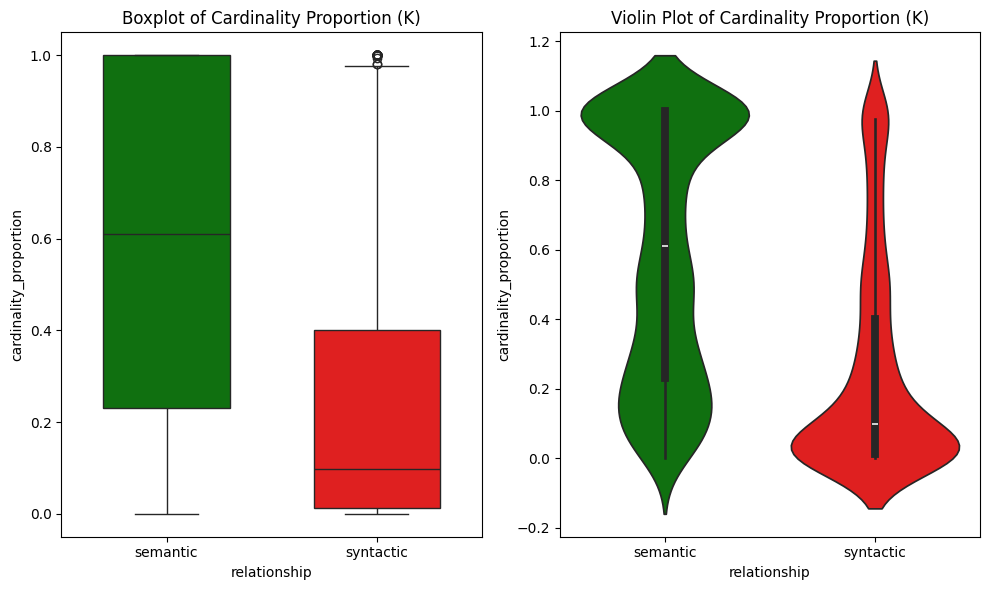

In [15]:
syntactic_only = pd.read_csv(f"syntactic_joins_{BENCHMARK_NAME}.csv")

# --- PREPARE DATA FOR PLOT ---
sample_size = 1500
semantic_plot = pd.read_csv(f"semantic_joins_{BENCHMARK_NAME}.csv")
semantic_plot["relationship"] = "semantic"

syntactic_only['cardinality_proportion'] = pd.to_numeric(syntactic_only['cardinality_proportion_x'], errors='coerce')
syntactic_sample = syntactic_only.sample(n=min(sample_size, len(syntactic_only)), random_state=0)
semantic_plot['cardinality_proportion'] = pd.to_numeric(semantic_plot['cardinality_proportion'], errors='coerce')

combined = pd.concat([semantic_plot, syntactic_sample]).reset_index(drop=True)

# --- VISUALIZATION ---
plt.figure(figsize=(10, 6))

# Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(
    x='relationship', y='cardinality_proportion', data=combined,
    palette={"syntactic": 'red', "semantic": 'green'}, width=0.6
)
plt.title('Boxplot of Cardinality Proportion (K)')

# Violin Plot
plt.subplot(1, 2, 2)
sns.violinplot(
    x='relationship', y='cardinality_proportion', data=combined,
    palette={"syntactic": 'red', "semantic": 'green'}
)
plt.title('Violin Plot of Cardinality Proportion (K)')

plt.tight_layout()
plt.show()
